In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os, logging
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
np.set_printoptions(linewidth=200)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

In [3]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
EXEC_TIME = 'lstm-' + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(f'../logs/{EXEC_TIME}', exist_ok=True)
logging.basicConfig(filename=f'../logs/{EXEC_TIME}/{EXEC_TIME}.log', level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
logging.getLogger().addHandler(logging.StreamHandler())

logging.debug(f'../logs/{EXEC_TIME}/{EXEC_TIME}.log')

../logs/lstm-20200323-003551/lstm-20200323-003551.log


In [5]:
TRAIN_RANGE = (datetime(1949, 1, 1), datetime(1956, 12, 1))
VALID_RANGE = (datetime(1957, 1, 1), datetime(1958, 12, 1))
TEST_RANGE = (datetime(1959, 1, 1), datetime(1960, 12, 1))
TIME_STEPS = 12  # 12 month to predict next month

In [6]:
data = pd.read_csv('../data/input/airline-passengers.csv')
data.index = pd.to_datetime(data.Month)
data['RawPassengers'] = data['Passengers']
data.drop(['Month', 'Passengers'], axis=1, inplace=True)

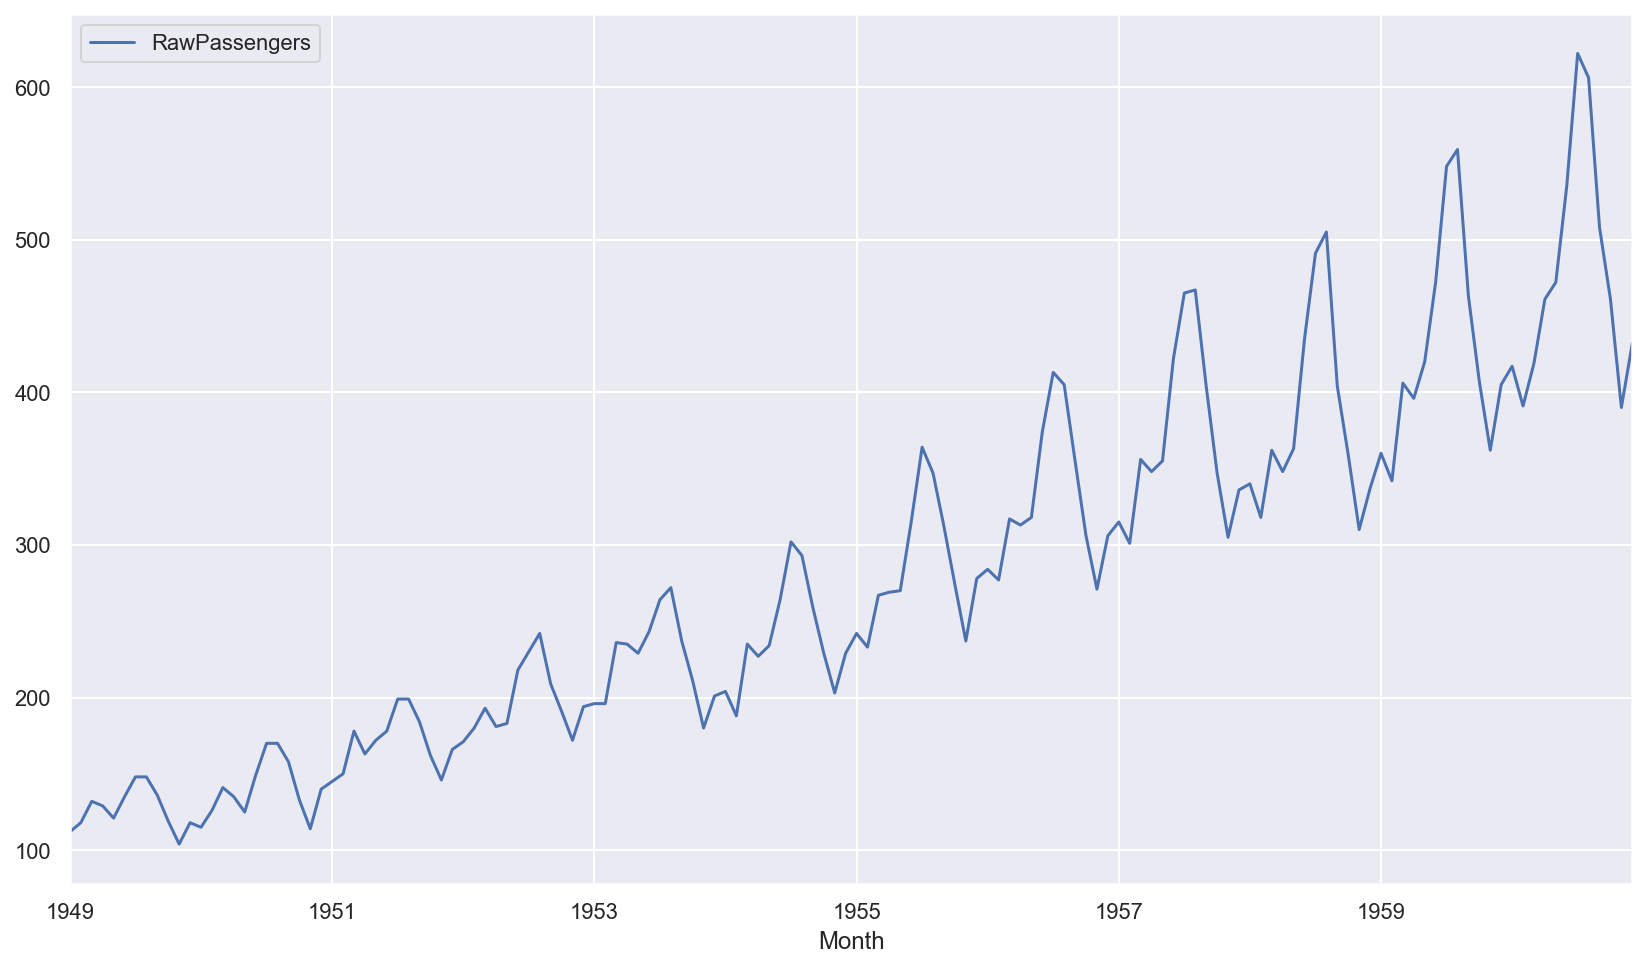

In [7]:
data.plot(figsize=(14, 8))

In [131]:
"""
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xs = np.arange(len(data[:TRAIN_RANGE[-1]]))
ys = data[:TRAIN_RANGE[-1]]['RawPassengers'].values

popt, pcov = curve_fit(func, xs, ys)
a, b, c = popt
xs = np.arange(len(data))
y_reg = a * np.exp(-b * xs) + c
"""

"\ndef func(x, a, b, c):\n    return a * np.exp(-b * x) + c\n\nxs = np.arange(len(data[:TRAIN_RANGE[-1]]))\nys = data[:TRAIN_RANGE[-1]]['RawPassengers'].values\n\npopt, pcov = curve_fit(func, xs, ys)\na, b, c = popt\nxs = np.arange(len(data))\ny_reg = a * np.exp(-b * xs) + c\n"

In [132]:
"""
data['Trend'] = y_reg
data['FlattenedPassengers'] = data['RawPassengers'] - data['Trend']
data.plot(figsize=(14, 8))
"""

"\ndata['Trend'] = y_reg\ndata['FlattenedPassengers'] = data['RawPassengers'] - data['Trend']\ndata.plot(figsize=(14, 8))\n"

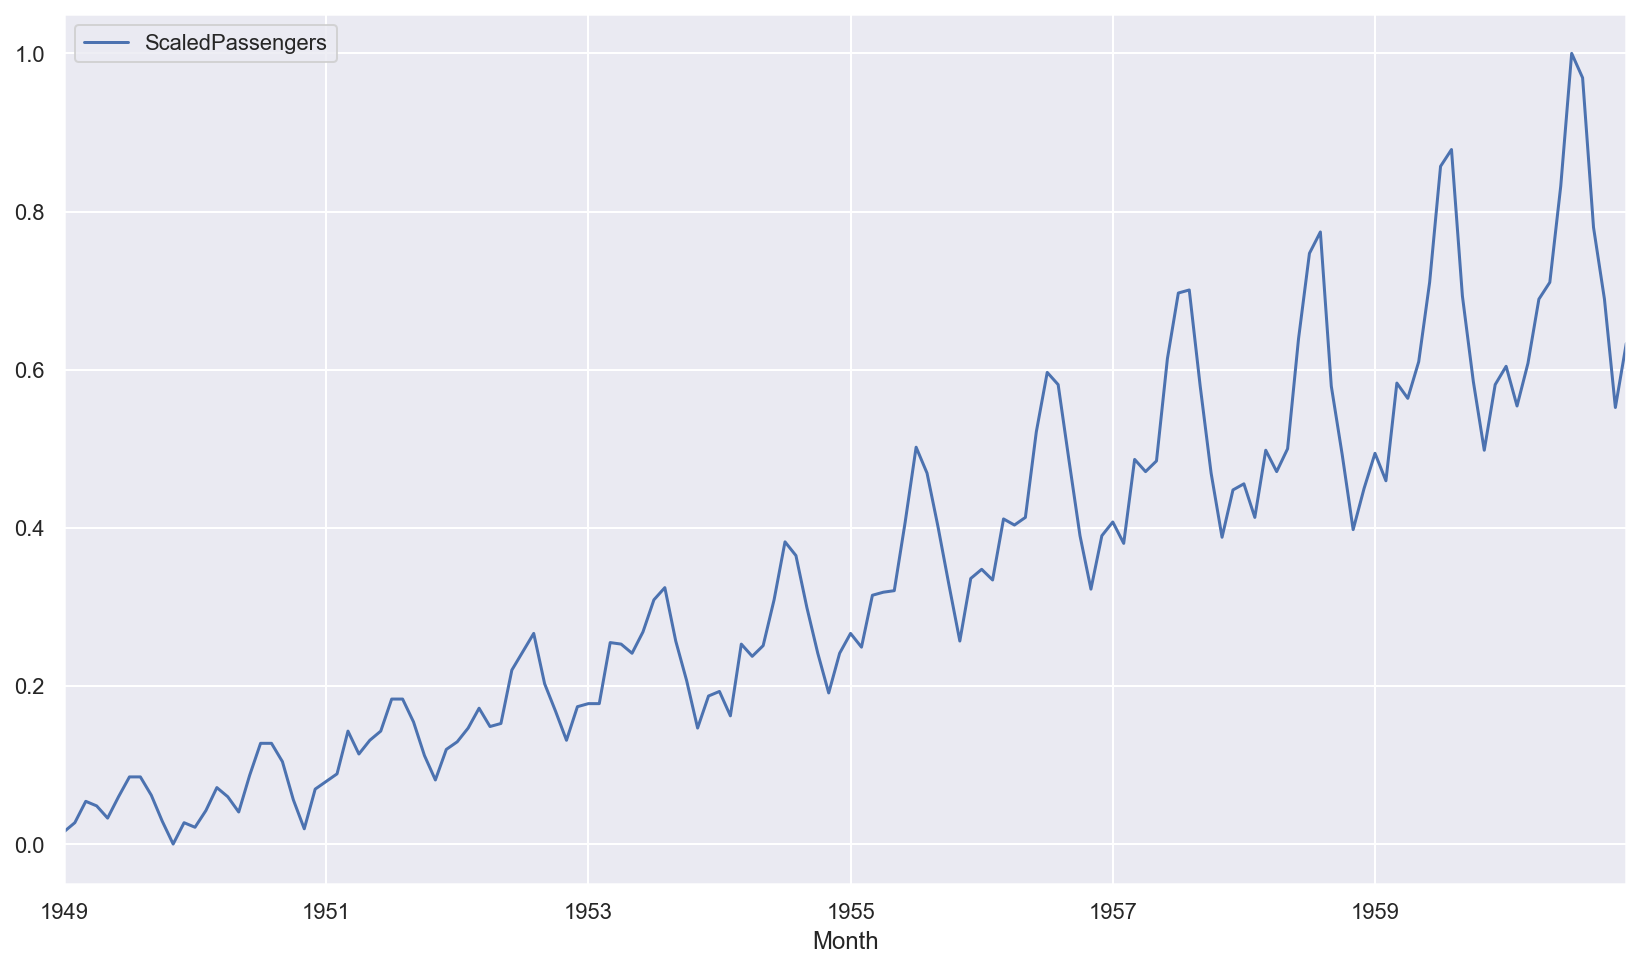

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['ScaledPassengers'] = scaler.fit_transform(data['RawPassengers'].values.reshape(-1, 1)).flatten()
data[['ScaledPassengers']].plot(figsize=(14, 8))

In [9]:
def create_dataset(data, time_steps=TIME_STEPS):
    X, y, y_date, head_values = [], [], [], []
    for i in range(len(data) - time_steps):
        Xt = data.iloc[i:i+time_steps].values
        head_value = Xt[0]
        head_values.append(head_value)
        sub_Xt = Xt - head_value
        yt = data.iloc[i+time_steps]
        sub_yt = yt - head_value
        yt_date = data.index[i+time_steps].to_pydatetime()
        X.append(sub_Xt)
        y.append(sub_yt)
        y_date.append(yt_date)
    return np.array(X), np.array(y), y_date, head_values

In [10]:
X, y, y_date, head_values = create_dataset(data[['ScaledPassengers']])

In [11]:
def split_train_valid_test(X, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])
    X_train = X[:train_end_idx+1, :]
    X_valid = X[train_end_idx+1:valid_end_idx+1, :]
    X_test = X[valid_end_idx+1:, :]
    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1]
    y_test = y[valid_end_idx+1:]
    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]
    return X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

In [12]:
X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X, y, y_date)

In [13]:
logging.debug(f'{X.shape}, {X_train.shape}, {X_valid.shape}, {X_test.shape}')
logging.debug(f'{y.shape}, {y_train.shape}, {y_valid.shape}, {y_test.shape}')

(132, 12, 1), (84, 12, 1), (24, 12, 1), (24, 12, 1)
(132, 1), (84, 1), (24, 1), (24, 1)


In [15]:
def create_model(time_steps=TIME_STEPS):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.01), metrics=['mean_absolute_error'])
    return model

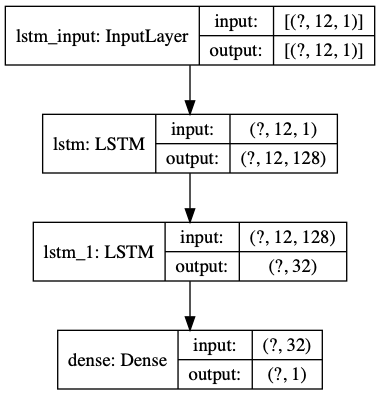

In [16]:
model = create_model()
plot_model(model, to_file=f'../logs/{EXEC_TIME}/model.png', show_shapes=True)

In [17]:
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=15, verbose=1, mode='auto')
fn = f'../logs/{EXEC_TIME}/trained_model.h5'
model_checkpoint = ModelCheckpoint(filepath=fn, save_best_only=True)
reduce_lr_on_plateau = ReduceLROnPlateau(factor=0.2, patience=7, verbose=1, min_lr=0.00001)
callbacks = [early_stopping, model_checkpoint, reduce_lr_on_plateau]
callbacks = [early_stopping, model_checkpoint]

In [18]:
fit = model.fit(
    X_train, y_train, 
    batch_size=32,
    epochs=1000, 
    verbose=2,
    validation_data=(X_valid, y_valid), 
    callbacks=callbacks)

Train on 84 samples, validate on 24 samples
Epoch 1/1000
84/84 - 3s - loss: 0.0249 - mean_absolute_error: 0.1263 - val_loss: 0.0095 - val_mean_absolute_error: 0.0828
Epoch 2/1000
84/84 - 0s - loss: 0.0042 - mean_absolute_error: 0.0541 - val_loss: 0.0036 - val_mean_absolute_error: 0.0516
Epoch 3/1000
84/84 - 0s - loss: 0.0022 - mean_absolute_error: 0.0389 - val_loss: 0.0013 - val_mean_absolute_error: 0.0308
Epoch 4/1000
84/84 - 0s - loss: 0.0014 - mean_absolute_error: 0.0297 - val_loss: 0.0019 - val_mean_absolute_error: 0.0356
Epoch 5/1000
84/84 - 0s - loss: 0.0015 - mean_absolute_error: 0.0322 - val_loss: 0.0012 - val_mean_absolute_error: 0.0290
Epoch 6/1000
84/84 - 0s - loss: 8.6603e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0016 - val_mean_absolute_error: 0.0327
Epoch 7/1000
84/84 - 0s - loss: 0.0013 - mean_absolute_error: 0.0293 - val_loss: 0.0015 - val_mean_absolute_error: 0.0308
Epoch 8/1000
84/84 - 0s - loss: 9.8666e-04 - mean_absolute_error: 0.0257 - val_loss: 0.0011 - val_

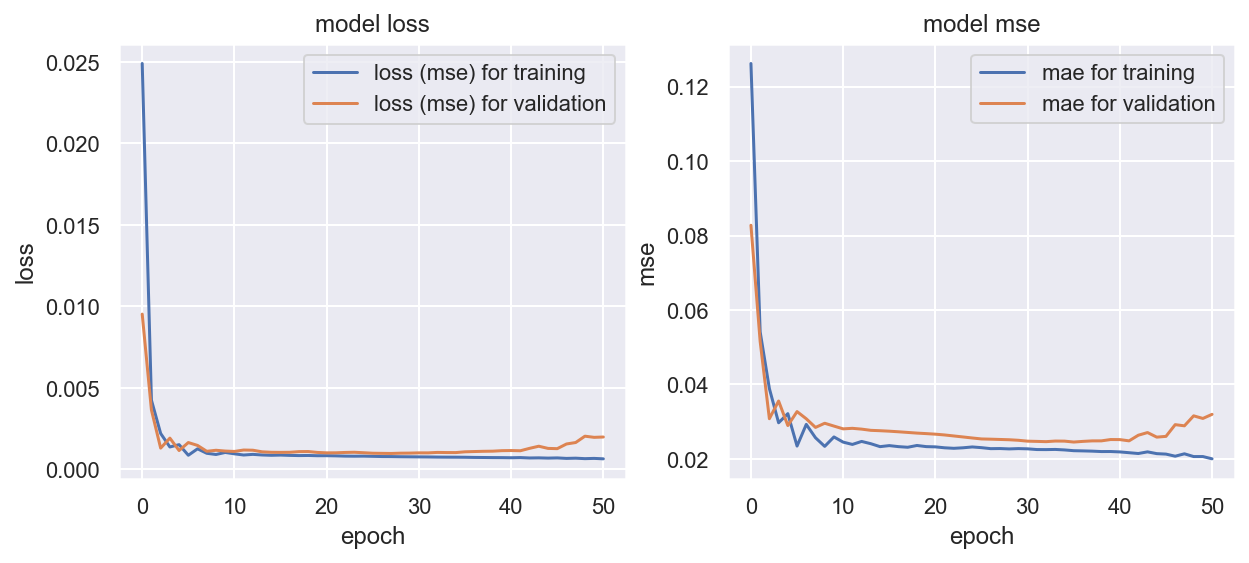

In [19]:
# 学習曲線をプロットする
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 4))
axL.plot(fit.history['loss'], label="loss (mse) for training")
axL.plot(fit.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(fit.history['mean_absolute_error'], label="mae for training")
axR.plot(fit.history['val_mean_absolute_error'], label="mae for validation")
axR.set_title('model mse')
axR.set_xlabel('epoch')
axR.set_ylabel('mse')
axR.legend(loc='upper right')

fig.savefig(f'../logs/{EXEC_TIME}/history.png')
plt.show()
plt.close()

# ベストのモデルをロードする
model = load_model(fn)

In [31]:
def evaluate_model(data, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, head_values, model):
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)
    pred_test = model.predict(X_test)
    
    pred_train  = pred_train + head_values[:len(X_train)]
    pred_valid  = pred_valid + head_values[len(X_train):len(X_train)+len(X_valid)]
    pred_test  = pred_test + head_values[len(X_train)+len(X_valid):]
    
    # pred_df = data[['RawPassengers', 'FlattenedPassengers', 'ScaledPassengers', 'Trend']].copy()
    pred_df = data[['RawPassengers', 'ScaledPassengers']].copy()
    
    pred_df.loc[y_date_train[0]:y_date_train[-1], 'ScaledPredTrain'] = pred_train
    pred_df.loc[y_date_valid[0]:y_date_valid[-1], 'ScaledPredValid'] = pred_valid
    pred_df.loc[y_date_test[0]:y_date_test[-1], 'ScaledPredTest'] = pred_test
    
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test = scaler.inverse_transform(pred_test).flatten()
    
    pred_df.loc[y_date_train[0]:y_date_train[-1], 'RawPredTrain'] = pred_train
    pred_df.loc[y_date_valid[0]:y_date_valid[-1], 'RawPredValid'] = pred_valid
    pred_df.loc[y_date_test[0]:y_date_test[-1], 'RawPredTest'] = pred_test
    
    # raw_pred_train = pred_train + pred_df.loc[y_date_train[0]:y_date_train[-1]]['Trend']
    # raw_pred_valid = pred_valid + pred_df.loc[y_date_valid[0]:y_date_valid[-1]]['Trend']
    # raw_pred_test = pred_test + pred_df.loc[y_date_test[0]:y_date_test[-1]]['Trend']
    
    # pred_df.loc[y_date_train[0]:y_date_train[-1], 'RawPredTrain'] = raw_pred_train
    # pred_df.loc[y_date_valid[0]:y_date_valid[-1], 'RawPredValid'] = raw_pred_valid
    # pred_df.loc[y_date_test[0]:y_date_test[-1], 'RawPredTest'] = raw_pred_test
    
    pred_df[['RawPassengers', 'RawPredTrain', 'RawPredValid', 'RawPredTest']].plot(figsize=(12, 6))
    fig.savefig(f'../logs/{EXEC_TIME}/prediction_result.png')
    fig.show()
    
    y_train  = y_train + head_values[:len(X_train)]
    y_valid  = y_valid + head_values[len(X_train):len(X_train)+len(X_valid)]
    y_test  = y_test + head_values[len(X_train)+len(X_valid):]
    
    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test = scaler.inverse_transform(y_test).flatten()
    
    # raw_y_train = y_train + pred_df.loc[y_date_train[0]:y_date_train[-1]]['Trend']
    # raw_y_valid = y_valid + pred_df.loc[y_date_valid[0]:y_date_valid[-1]]['Trend']
    # raw_y_test = y_test + pred_df.loc[y_date_test[0]:y_date_test[-1]]['Trend']
    
    for y, pred, mode in zip([y_train, y_valid, y_test], [pred_train, pred_valid, pred_test], ['train', 'valid', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        logging.debug(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

train rmse: 14.439494, mae: 11.746364
valid rmse: 16.192093, mae: 13.064327
test rmse: 22.662299, mae: 18.277842


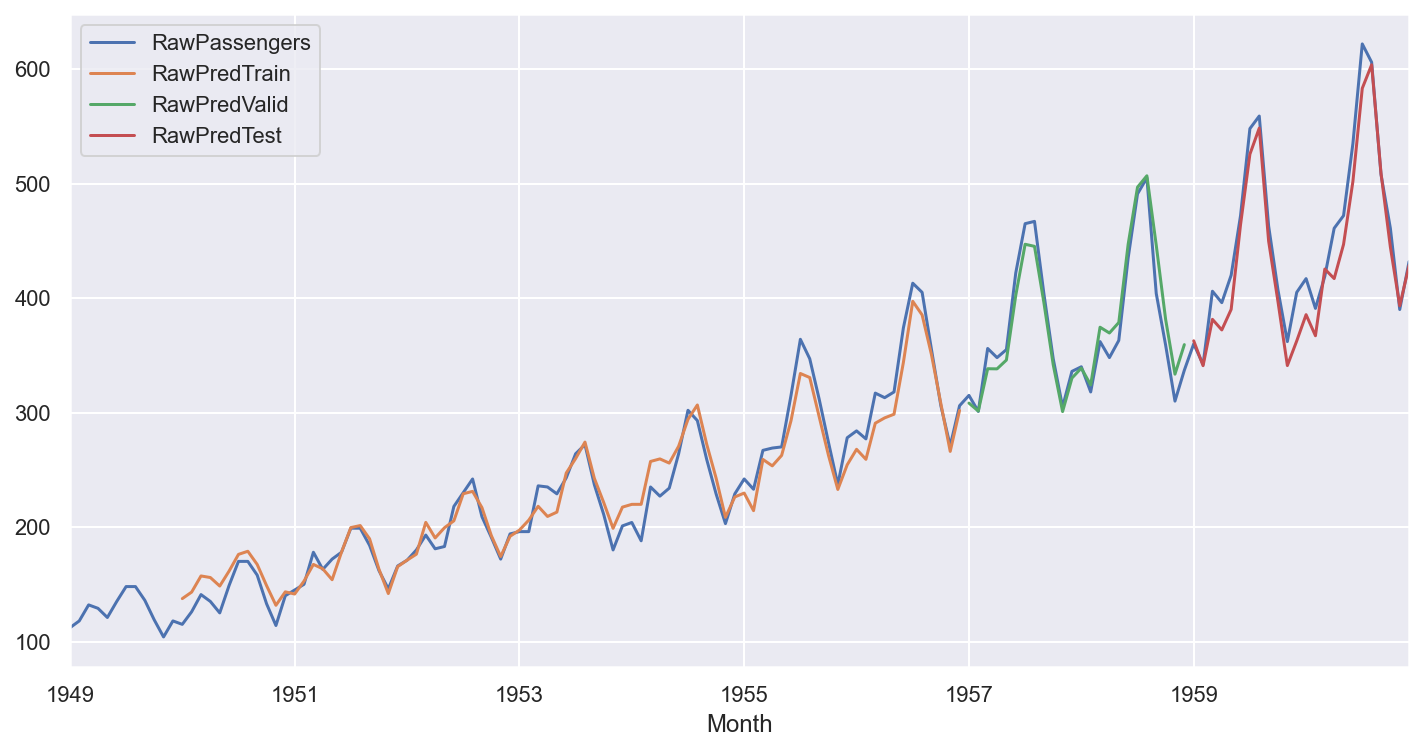

In [32]:
evaluate_model(data, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, head_values, model)

In [33]:
LAYER = 'lstm_1'
intermediate_model = Model(inputs=model.input, outputs=model.get_layer(LAYER).output)

train_activation = intermediate_model.predict(X_train)
valid_activation = intermediate_model.predict(X_valid)
test_activation = intermediate_model.predict(X_test)
print(train_activation.shape, valid_activation.shape, test_activation.shape)

(84, 32) (24, 32) (24, 32)
